## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `creditcard.csv` que contém 31 colunas. Esse problema é o de detectar fraude em transações em cartões de crédito. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.<br><br>

<font color="blue">
Você deverá criar um notebook (ipynb) com a solução. O Notebook deverá conter as saídas para visualização dos resultados. Fazer upload no Moodle de 2 arquivos:</font>

<font color="blue">1. Notebook com o código fonte (ipynb)</font><br>
<font color="blue">2. Versão em PDF com todos os resultados</font>

Conforme código abaixo, use como características de entrada as colunas de posição 1 até 28 (marcadas no arquivo como V1 - V28), e como classe a última coluna (Class). Não utilize a coluna Amount.

As tarefas a realizar são as seguintes:

1. **Separe** os dados em:
    * conjunto S = 2,5% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2,5%, ou 7120 exemplos), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
1. **Modelo A**: denoising overcomplete autoencoder para pré-treinamento baseado em auto-supervisão
    * Arquitetura com as seguintes camadas:
        * entrada com 28 valores
        * normalização em batch
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * dropout 0.2
        * normalização em batch
        * densa 28 neurônios, relu (camada de código/bottleneck)
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * densa 28 neurônios, tanh
    * Inserção de ruído aleatório uniforme ponderado a 0.2 (insira ruído nos dados de treinamento fornecidos por entrada, mas mantenha a comparação com a saída sem ruído, como num denoising autoencoder)
    * Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br><br>
1. **Análise de projeção das características**: visualize um scatterplot com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes:
    * scatterplot com projeção PCA do conjunto de S original
    * scatterplot com projeção PCA do conjunto S após processado pelo "encoder", ou seja resultado da saída da camada de código<br><br>
    
1. **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A, e inserindo uma nova camada densa de classificação com ativação sigmóide.<br>
    * Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
    * Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
    * Treinar com perda MSE por 8 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. **Avalie a rede neural de classificação**: 
    * Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas
    * Exiba precisão e revocação calculada no treinamento S e teste T
    * Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)<br><br>

1. **Bônus:** (+1 ponto extra) compare a solução com duas outras possibilidades que não envolvam uso do conjunto **U** não rotulado
    * Rede neural profunda com a mesma arquitetura e estratégias usadas no modelo B, mas sem usar os pesos pré-treinados, inicializando e treinando com os dados em S por 15 épocas. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados originais S. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

seed(1)
set_seed(2)

In [2]:
import pandas as pd
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Parte 1: separar dados

#### Conjunto df
- Tamanho: 284.807 Registros
- Variáveis: 30 Variáveis (28 utilizadas)
- Classes: 2 Classes

In [3]:
X = df.filter(regex='[v\d+]').copy()
y = df[['Class']].copy()
size = len(df)

print(f'Conjunto df:\n{X.shape[1]} Variáveis | {y.nunique()[0]} Classes | {size} Registros')

Conjunto df:
28 Variáveis | 2 Classes | 284807 Registros


#### Conjunto S
- Tamanho: 2,5% iniciais de df
- Variáveis: 28 Variáveis
- Classes: 2 Classes

In [4]:
S = [X.iloc[:int(size*0.025)].copy(), y.iloc[:int(size*0.025)].copy()]

print(f'Conjunto S:\n{S[0].shape[1]} Variáveis | {S[1].nunique()[0]} Classes | {S[0].shape[0]} Registros')

Conjunto S:
28 Variáveis | 2 Classes | 7120 Registros


#### Conjunto U
- Tamanho: 50% iniciais de df
- Variáveis: 28 Variáveis
- Classes: 2 Classes

In [5]:
U = [X.iloc[:int(size/2)].copy(), y.iloc[:int(size/2)].copy()]

print(f'Conjunto U:\n{U[0].shape[1]} Variáveis | {U[1].nunique()[0]} Classes | {U[0].shape[0]} Registros')

Conjunto U:
28 Variáveis | 2 Classes | 142403 Registros


#### Conjunto T
- Tamanho: 50% finais de df
- Variáveis: 28 Variáveis
- Classes: 2 Classes

In [6]:
T = [X.iloc[int(size/2):].copy(), y.iloc[int(size/2):].copy()]

print(f'Conjunto T:\n{T[0].shape[1]} Variáveis | {T[1].nunique()[0]} Classes | {T[0].shape[0]} Registros')

Conjunto T:
28 Variáveis | 2 Classes | 142404 Registros


### Parte 2: Modelo A

In [7]:
input_data = keras.layers.Input(shape=28)
network = keras.layers.BatchNormalization()(input_data)
# densa 32 neurônios, relu
network = keras.layers.Dense(32, activation='relu')(network)
# densa 32 neurônios, relu
network = keras.layers.Dense(32, activation='relu')(network)
# dropout 0.2
network = keras.layers.Dropout(0.2)(network)
# normalização em batch
network = keras.layers.BatchNormalization()(network)
# densa 28 neurônios, relu (camada de código/bottleneck)
network = keras.layers.Dense(28, activation='relu', name='code')(network)
# densa 32 neurônios, relu
network = keras.layers.Dense(32, activation='relu')(network)
# densa 32 neurônios, relu
network = keras.layers.Dense(32, activation='relu')(network)
# densa 28 neurônios, tanh
output = keras.layers.Dense(28, activation = 'tanh')(network)

modelA = keras.models.Model(input_data, output)

In [8]:
modelA.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [9]:
batch_size = 16
epochs = 20
noise_factor = 0.2

In [10]:
x_train = np.array(U[0])

x_train_noised = x_train + noise_factor * np.random.normal(0, 1, x_train.shape)

In [11]:
def scheduler_modelA(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4) 

In [12]:
callback = keras.callbacks.LearningRateScheduler(scheduler_modelA)

In [13]:
modelA.compile(
            loss = 'mse',
            optimizer = keras.optimizers.Adam(lr = 0.003)
            )

In [14]:
histA = modelA.fit(
        x = x_train_noised,
        y = x_train,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [callback],
        verbose = 1
        )

Epoch 1/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.6200
Epoch 2/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5616
Epoch 3/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5504
Epoch 4/20
8901/8901 [==============================] - 40s 4ms/step - loss: 0.5438
Epoch 5/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5379
Epoch 6/20
8901/8901 [==============================] - 40s 4ms/step - loss: 0.5316
Epoch 7/20
8901/8901 [==============================] - 40s 4ms/step - loss: 0.5265
Epoch 8/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5236
Epoch 9/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5208
Epoch 10/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5192
Epoch 11/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5174
Epoch 12/20
8901/8901 [==============================] - 39s 4ms/step - lo

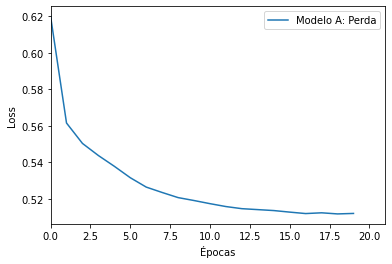

In [15]:
plt.plot(histA.history['loss'])
plt.xlim(0, 21)
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend(['Modelo A: Perda'])
plt.show();

### Parte 3: Análise da projeção das características

In [18]:
from sklearn.decomposition import PCA

In [24]:
x_train = np.array(S[0])
y_train = np.array(S[1])

In [25]:
x_train

array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
        -1.89114844e-01,  1.33558377e-01, -2.10530535e-02],
       [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
         1.25894532e-01, -8.98309914e-03,  1.47241692e-02],
       [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
        -1.39096572e-01, -5.53527940e-02, -5.97518406e-02],
       ...,
       [ 9.59621075e-01, -9.05450549e-01,  8.53909168e-01, ...,
         1.32851384e-01,  2.17926096e-03,  2.23720913e-02],
       [-1.44561337e+00,  1.93566277e-03,  2.37966495e+00, ...,
         3.99510270e-01, -1.98342533e-01,  1.45150079e-01],
       [-3.70107041e+00,  2.77712991e+00,  1.14104167e+00, ...,
         3.25280394e-01,  7.24562720e-01,  1.52023078e-01]])

In [26]:
pca = PCA(n_components = 2)
pca.fit(x_train)
pca_train = pca.transform(x_train)

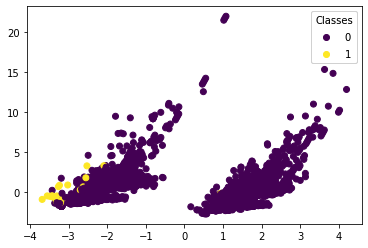

In [27]:
fig, ax = plt.subplots()
scatter = ax.scatter(
                    pca_train[:,0]
                ,   pca_train[:,1]
                ,   c = y_train[:]
                ,   cmap='viridis'
                )
legend = ax.legend(
                    *scatter.legend_elements()
                ,   loc='best'
                ,   title='Classes'
                )
ax.add_artist(legend);

In [28]:
modelCode = keras.models.Model(
                            inputs = modelA.input
                        ,   outputs = modelA.get_layer('code').output
                        )

In [29]:
codeTrain = np.asarray(modelCode.predict(x_train))

In [30]:
pca = PCA(n_components = 2)
pca.fit(codeTrain)
pca_train = pca.transform(codeTrain)

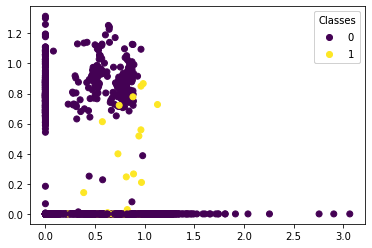

In [31]:
fig, ax = plt.subplots()
scatter = ax.scatter(
                    codeTrain[:,0]
                ,   codeTrain[:,1]
                ,   c = y_train[:]
                ,   cmap='viridis'
                )
legend = ax.legend(
                    *scatter.legend_elements()
                ,   loc='best'
                ,   title='Classes'
                )
ax.add_artist(legend);

### Parte 4: Modelo B

In [33]:
encoder = keras.models.Model(
                        inputs = modelA.input
                    ,   outputs = modelA.get_layer(name = 'code').output
                    )

In [34]:
update_model = keras.models.Sequential()
update_model.add(
                keras.layers.Dense(
                    1,
                    activation = 'sigmoid',
                    name = 'pred',
                    input_shape = encoder.output_shape[1:]
                    )
                )

modelB = keras.models.Model(
    inputs = encoder.input,
    outputs = update_model(encoder.output)
    )

In [35]:
modelB.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [36]:
batch_size = 16
epochs = 8
class_weight = {0: 0.1, 1: 0.9}

In [37]:
x_train = np.array(U[0])
y_train = np.array(U[1])

In [38]:
def scheduler_modelB(epoch, lr):
    return np.round(lr * tf.math.exp(-0.3),4)    

In [39]:
callback = keras.callbacks.LearningRateScheduler(scheduler_modelB)

In [40]:
modelB.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(lr = 0.001),
    metrics = [
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
            ]
    )

In [42]:
histB = modelB.fit(
                x = x_train,
                y = y_train,
                batch_size = batch_size,
                epochs = epochs,
                callbacks = [ callback ],
                class_weight = class_weight,
                verbose = 1
                )

Epoch 1/8
8901/8901 [==============================] - 58s 6ms/step - loss: 7.8191e-04 - precision: 0.6736 - recall: 0.6059
Epoch 2/8
8901/8901 [==============================] - 53s 6ms/step - loss: 3.7629e-04 - precision: 0.7726 - recall: 0.7955
Epoch 3/8
8901/8901 [==============================] - 55s 6ms/step - loss: 3.5011e-04 - precision: 0.7711 - recall: 0.8141
Epoch 4/8
8901/8901 [==============================] - 57s 6ms/step - loss: 3.4591e-04 - precision: 0.7794 - recall: 0.8141
Epoch 5/8
8901/8901 [==============================] - 56s 6ms/step - loss: 3.3079e-04 - precision: 0.7809 - recall: 0.8216
Epoch 6/8
8901/8901 [==============================] - 56s 6ms/step - loss: 3.4385e-04 - precision: 0.7766 - recall: 0.8141
Epoch 7/8
8901/8901 [==============================] - 57s 6ms/step - loss: 3.3039e-04 - precision: 0.7957 - recall: 0.8253
Epoch 8/8
8901/8901 [==============================] - 57s 6ms/step - loss: 3.1574e-04 - precision: 0.7805 - recall: 0.8327


### Parte 5: Avaliação da rede neural de classificação

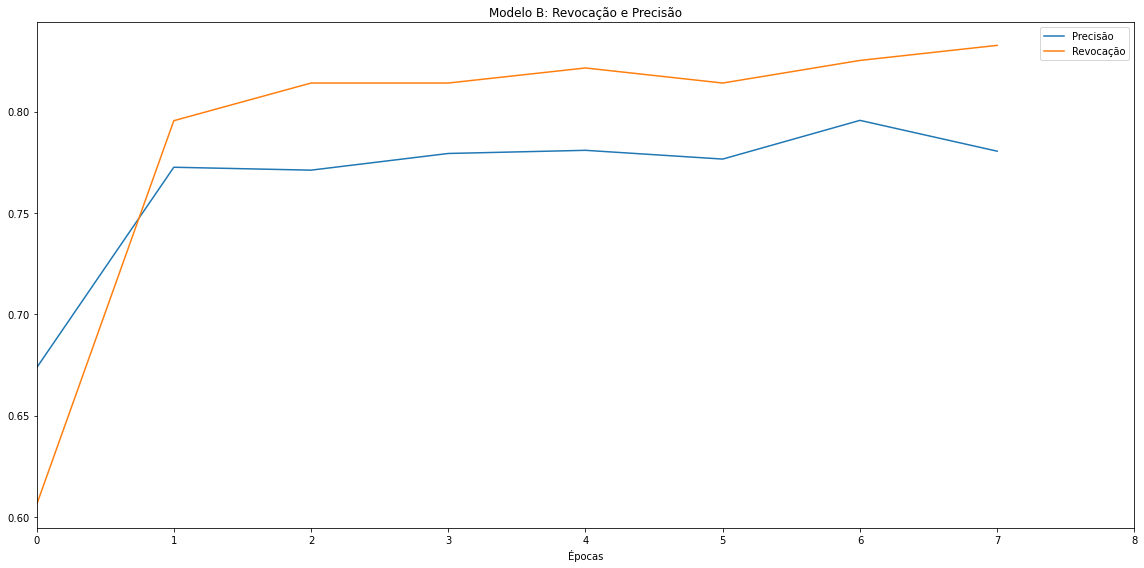

In [47]:
fig, axes = plt.subplots(figsize = (16,8))

plt.plot(histB.history['precision'], label = 'precision')
plt.plot(histB.history['recall'], label = 'recall')

plt.title('Modelo B: Revocação e Precisão')
plt.xlabel('Épocas')
plt.xlim(0, 8)
plt.legend(['Precisão', 'Revocação'], loc = 'best')
fig.tight_layout()
plt.show();

In [49]:
score_S = modelB.evaluate(S[0], S[1], verbose=0)
print(f'Conjunto S:\nPrecisão: {np.round(score_S[1], 4)}\nRevocação: {np.round(score_S[2], 4)}')

Conjunto S:
Precisão: 0.92
Revocação: 0.92


In [50]:
score_T = modelB.evaluate(T[0], T[1], verbose=0)
print(f'Conjunto T:\nPrecisão: {np.round(score_T[1], 4)}\nRevocação: {np.round(score_T[2], 4)}')

Conjunto T:
Precisão: 0.8469
Revocação: 0.7444


In [48]:
codeModel = keras.models.Model(
    inputs = modelB.input,
    outputs = modelB.get_layer('code').output
    )

In [54]:
trainCode = np.asarray(codeModel.predict(S[0]))

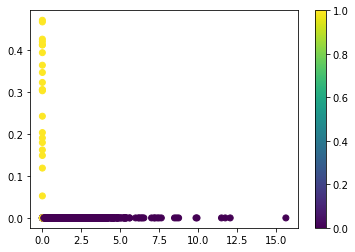

In [56]:
plt.scatter(
    trainCode[:,0], trainCode[:,1], c = S[1][:].values, cmap='viridis'
    )
plt.colorbar();

### Bônus: Tentando outros métodos para treinar com os poucos dados rotulados

#### Tentativa 1: DNN com a mesma arquitetura usada, mas sem pré-treinamento

In [57]:
encoderBonus = keras.models.Model(
                inputs = modelA.input,
                outputs = modelA.get_layer(name = 'code').output
            )

In [58]:
update_model = keras.models.Sequential()
update_model.add(
    keras.layers.Dense(
        1,
        activation = 'sigmoid',
        name = 'pred',
        input_shape = encoderBonus.output_shape[1:]
        )
    )

modelDNN = keras.models.Model(
    inputs = encoderBonus.input,
    outputs = update_model(encoderBonus.output)
    )

In [59]:
modelDNN.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)              

In [ ]:
batch_size = 16
epochs = 15


#### Tentativa 2: SVM nos dados originais

In [22]:
#### 